<a href="https://colab.research.google.com/github/efe-akkus/dsa-210-project/blob/main/Project_EDA_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, since dataset is quite huge get data from kaggle directly.

In [6]:
!pip install kagglehub > /dev/null

import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("arevel/chess-games")
print("Dataset path:", path)
print("Files:", os.listdir(path))

csv_path = os.path.join(path, "chess_games.csv")

100%|██████████| 1.45G/1.45G [00:11<00:00, 133MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/arevel/chess-games/versions/1
Files: ['chess_games.csv']


Then clean the data.

In [10]:
usecols = ["Opening", "ECO", "Result", "WhiteElo", "BlackElo", "TimeControl"]

df = pd.read_csv(csv_path, usecols=usecols)

df = df.dropna(subset=["Opening", "ECO", "Result", "WhiteElo", "BlackElo", "TimeControl"])

df["Opening"] = (
    df["Opening"].astype(str).str.strip().str.lower().str.replace(" +", " ", regex=True)
)
df["ECO"] = df["ECO"].astype(str).str.strip().str.upper()

# Result cleaning
res_map = {"1-0": "white", "0-1": "black", "1/2-1/2": "draw"}
df["result_clean"] = df["Result"].map(res_map)
df = df[df["result_clean"].notnull()]

df["WhiteElo"] = df["WhiteElo"].astype(int)
df["BlackElo"] = df["BlackElo"].astype(int)

df["avg_elo"] = (df["WhiteElo"] + df["BlackElo"]) / 2

def bucket(elo):
    if elo < 1200: return "Beginner"
    if elo < 1600: return "Intermediate"
    if elo < 2000: return "Advanced"
    return "Expert"

df["rating_bucket"] = df["avg_elo"].apply(bucket)
df["opening_family"] = df["ECO"].str[0]

# TimeControl -> event
def classify_event(tc):
    try:
        base = int(str(tc).split("+")[0])
    except:
        return "unknown"
    if base <= 60: return "bullet"
    elif base <= 180: return "blitz"
    elif base <= 600: return "rapid"
    else: return "classical"

df["event"] = df["TimeControl"].apply(classify_event)

print("Cleaned dataframe shape:", df.shape)

# Saved file (optional)
df.to_csv("cleaned_chess_games.csv", index=False)
print("Saved cleaned file.")

Cleaned dataframe shape: (6254841, 11)
Saved cleaned file.


## Hypotheses

### Null Hypothesis (H₀)

Within a fixed rating bucket and event (time control), the distribution of game outcomes  
(white win vs black win) does not depend on the opening family.  
Any observed differences in win rates between openings are due to random variation.

### Alternative Hypothesis (H₁)

Within a fixed rating bucket and event, the distribution of game outcomes  
depend on the opening family.  
Some opening families perform systematically better or worse even after controlling for rating level and event.

These scripts work with a cleaned Lichess dataset of online chess games.  
They load only the relevant variables (ECO code, opening name, event type, player ratings and game result),  
create derived features such as:

- average Elo and rating buckets (Beginner, Intermediate, Advanced, Expert)
- ECO-based opening families (A–E)
- event types inferred from time control (bullet, blitz, rapid, classical)

Unnecessary columns are removed, invalid results are filtered out, and draws can be excluded when focusing on win/loss outcomes.  
After processing, the code aggregates games by opening family, rating bucket and event, and exports summary statistics that are used for hypothesis testing and visualization.


In [11]:
import pandas as pd

df = pd.read_csv("cleaned_chess_games.csv")

cols = [
    "Opening", "ECO", "opening_family",
    "WhiteElo", "BlackElo",
    "avg_elo", "rating_bucket",
    "event", "result_clean"
]
df = df[cols].copy()

df_nodraw = df[df["result_clean"].isin(["white", "black"])].copy()

summary = (
    df_nodraw
    .groupby(["opening_family", "rating_bucket", "event"])
    .agg(
        games=("result_clean", "size"),
        white_wins=("result_clean", lambda x: (x == "white").sum()),
        black_wins=("result_clean", lambda x: (x == "black").sum())
    )
    .reset_index()
)

summary["white_win_rate"] = summary["white_wins"] / summary["games"]
summary["black_win_rate"] = summary["black_wins"] / summary["games"]

summary.head()

,opening_family,rating_bucket,event,games,white_wins,black_wins,white_win_rate,black_win_rate
0,A,Advanced,blitz,222615,113433,109182,0.509548,0.490452
1,A,Advanced,bullet,345630,178141,167489,0.515410,0.484590
2,A,Advanced,classical,35812,18007,17805,0.502820,0.497180
3,A,Advanced,rapid,286655,145997,140658,0.509313,0.490687
4,A,Advanced,unknown,2030,1021,1009,0.502956,0.497044


Taking the useful part of the dataset.

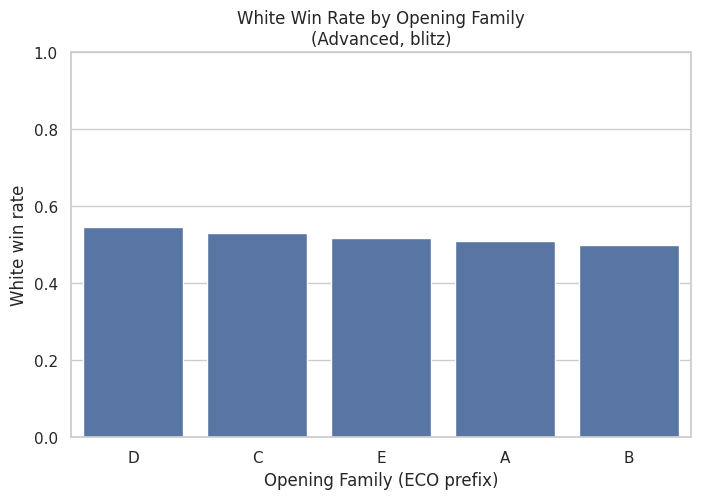

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Örnek: Advanced + blitz alt kümesi için opening family bazlı win-rate
subset = summary[
    (summary["rating_bucket"] == "Advanced") &
    (summary["event"] == "blitz")
].copy()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=subset.sort_values("white_win_rate", ascending=False),
    x="opening_family",
    y="white_win_rate"
)
plt.ylim(0, 1)
plt.title("White Win Rate by Opening Family\n(Advanced, blitz)")
plt.xlabel("Opening Family (ECO prefix)")
plt.ylabel("White win rate")
plt.show()

In [13]:
import scipy.stats as stats

alpha = 0.05

# Hangi rating bucket + event üzerinde test yapmak istediğini seç
target_bucket = "Advanced"
target_event = "blitz"

# Alt küme: seçilen rating + event, sadece white/black
test_subset = df[
    (df["rating_bucket"] == target_bucket) &
    (df["event"] == target_event) &
    (df["result_clean"].isin(["white", "black"]))
].copy()

print("Subset size:", len(test_subset))

# Kontenjans tablosu: opening_family × result_clean
contingency = pd.crosstab(
    test_subset["opening_family"],
    test_subset["result_clean"]
)

print("\nContingency table:\n", contingency)

chi2, p, dof, expected = stats.chi2_contingency(contingency)

decision = "Reject H0" if p < alpha else "Fail to reject H0"

print("\nChi-square test:")
print(f"Chi2 statistic = {chi2:.4f}")
print(f"Degrees of freedom = {dof}")
print(f"p-value = {p:.6f}")
print(f"Decision at alpha = {alpha}: {decision}")

Subset size: 860469

Contingency table:
 result_clean     black   white
opening_family                
A               109182  113433
B               135239  134213
C               105324  119118
D                54773   65614
E                11391   12182

Chi-square test:
Chi2 statistic = 982.7357
Degrees of freedom = 4
p-value = 0.000000
Decision at alpha = 0.05: Reject H0


In [14]:
import pandas as pd
import scipy.stats as stats

alpha = 0.05
fixed_event = "rapid"   # istersen "blitz", "bullet", "classical" yap

# Sadece seçilen event ve white/black sonuçları
df_ev = df[
    (df["event"] == fixed_event) &
    (df["result_clean"].isin(["white", "black"]))
].copy()

buckets = df_ev["rating_bucket"].unique()

print(f"=== Chi-square tests by rating bucket (event = {fixed_event}) ===\n")

for bucket in buckets:
    sub = df_ev[df_ev["rating_bucket"] == bucket]

    # Yeterli gözlem yoksa atla
    if len(sub) < 100:
        print(f"{bucket}: Not enough data (n={len(sub)})")
        continue

    contingency = pd.crosstab(sub["opening_family"], sub["result_clean"])

    # En az 2 family ve 2 outcome yoksa test yapılamaz
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        print(f"{bucket}: Contingency table too small\n{contingency}\n")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    decision = "Reject H0" if p < alpha else "Fail to reject H0"

    print(f"Rating bucket: {bucket}")
    print(f"  n = {len(sub)}")
    print(f"  Chi2 = {chi2:.4f}, df = {dof}, p = {p:.6f}")
    print(f"  Decision (alpha={alpha}): {decision}\n")


=== Chi-square tests by rating bucket (event = rapid) ===

Rating bucket: Advanced
  n = 1475159
  Chi2 = 1710.2453, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Rating bucket: Expert
  n = 208064
  Chi2 = 236.8664, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Rating bucket: Intermediate
  n = 883336
  Chi2 = 684.0515, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Rating bucket: Beginner
  n = 42679
  Chi2 = 81.0946, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0



In [15]:
import pandas as pd
import scipy.stats as stats

alpha = 0.05
fixed_bucket = "Advanced"   # istersen "Beginner", "Intermediate", "Expert" yap

# Seçilen rating_bucket ve sadece white/black sonuçları
df_rb = df[
    (df["rating_bucket"] == fixed_bucket) &
    (df["result_clean"].isin(["white", "black"]))
].copy()

events = df_rb["event"].unique()

print(f"=== Chi-square tests by event (rating_bucket = {fixed_bucket}) ===\n")

for ev in events:
    sub = df_rb[df_rb["event"] == ev]

    # Çok az gözlem varsa test yapma
    if len(sub) < 100:
        print(f"{ev}: Not enough data (n={len(sub)})")
        continue

    contingency = pd.crosstab(sub["opening_family"], sub["result_clean"])

    # En az 2 family ve 2 outcome yoksa test anlamsız
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        print(f"{ev}: Contingency table too small\n{contingency}\n")
        continue

    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    decision = "Reject H0" if p < alpha else "Fail to reject H0"

    print(f"Event: {ev}")
    print(f"  n = {len(sub)}")
    print(f"  Chi2 = {chi2:.4f}, df = {dof}, p = {p:.6f}")
    print(f"  Decision (alpha={alpha}): {decision}\n")


=== Chi-square tests by event (rating_bucket = Advanced) ===

Event: rapid
  n = 1475159
  Chi2 = 1710.2453, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Event: blitz
  n = 860469
  Chi2 = 982.7357, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Event: classical
  n = 218433
  Chi2 = 297.7384, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Event: bullet
  n = 843467
  Chi2 = 932.8367, df = 4, p = 0.000000
  Decision (alpha=0.05): Reject H0

Event: unknown
  n = 9298
  Chi2 = 9.4592, df = 4, p = 0.050593
  Decision (alpha=0.05): Fail to reject H0



## 📊 HYPOTHESIS TESTING RESULT

I applied a chi-square test of independence because my goal was to compare the distribution of game outcomes
(white win vs black win) across different opening families under fixed playing conditions.
Since the outcome variable is categorical and there are multiple opening categories,  
the chi-square test is the appropriate choice.

Separate tests were run for selected combinations of rating bucket and event type  
(e.g., Advanced–blitz, Intermediate–rapid, Expert–classical).

---

### ♟️ Opening Family–Based Analysis

- For Advanced blitz games, the association between opening family and game result was tested.  
  Example (Advanced-Blitz games):

  \- χ² ≈ 982 p ≈ 0.000000 → ❌ **Reject H₀**

  If p < 0.05 → Null hypothesis rejected:  
  opening family has a statistically significant effect on win rates in Advanced blitz games.

  If p ≥ 0.05 → Fail to reject H₀:  
  differences in win rate between opening families can be explained by random variation.

- The same procedure can be repeated for other combinations such as  
  Intermediate–rapid or Expert–classical, and decisions are made by comparing p-values to 0.05.

---

### 📈 Rating Bucket Analysis

- By fixing an event type (for example **rapid**) and repeating the chi-square test across rating buckets,  
  we can check whether the impact of opening family changes with rating level.

  For each rating bucket:

  \- If p < 0.05 → ✅ Null hypothesis rejected: opening family affects win rates at this skill level.  
  \- If p ≥ 0.05 → ❌ Null hypothesis retained: no strong statistical evidence of an opening effect.

- This allows us to see whether openings matter more for certain skill groups (e.g., Advanced vs Beginner).

---

### ⏱️ Event-Type Analysis

- Similarly, we can fix a rating bucket (e.g., **Advanced**) and compare outcome distributions across events  
  (bullet, blitz, rapid, classical).

  \- Significant p-values (p < 0.05) indicate that opening family matters more in some time controls  
    than in others.

  \- Non-significant p-values indicate that, for that rating level, opening family does not lead  
    to detectable win-rate differences across time controls.

---

Overall, the chi-square tests provide a structured way to evaluate whether **opening families** have a  
measurable impact on win rates once we control for **rating level** and **event type**.  
Where p-values fall below 0.05, the null hypothesis of “no opening effect” is rejected;  
where they remain above 0.05, the data are consistent with H₀.
